# PCA 迷你项目 
### 使用特征脸方法和 SVM 进行脸部识别
我们在讨论 PCA 时花了很长的时间讨论理论问题，因此，在此迷你项目中，我们将请你研究一些 sklearn 代码。特征脸代码很有趣并且很丰富，足以当做此迷你项目的实验台。



注意：
在此示例中使用的数据集来自“[Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/)”，亦称为 [LFW_ Download](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz) (233MB) 并经过预处理。这是[原始数据](http://scikit-learn.org/0.15/auto_examples/applications/face_recognition.html)。

In [1]:
from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA
from sklearn.svm import SVC

## 加载数据集

In [2]:
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people('data', min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)


# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print( "n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


### 拆分为训练集和测试集

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## 计算 PCA

我们现在可以对脸部数据集（当做无标签数据集）计算 [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)（特征脸）了：无监督式特征提取/降维。

In [4]:
n_components = 150

print( "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]) )
t0 = time()

# TODO: Create an instance of PCA, initializing with n_components=n_components and whiten=True
pca = PCA(n_components=n_components, whiten=True, svd_solver='randomized')

#TODO: pass the training dataset (X_train) to pca's 'fit()' method
pca = pca.fit(X_train)


print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 0.108s


将输入数据投射到特征脸标准正交基

In [5]:
eigenfaces = pca.components_.reshape((n_components, h, w))

t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


done in 0.017s


## 训练 SVM 分类模型

我们将 [SVM 分类器](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)拟合到训练集中。我们将使用 [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) 为该分类器找到一组合适的参数。

In [6]:
param_grid = {
          'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }

# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)

print("Best estimator found by grid search:")
print(clf.best_estimator_)

/anaconda2/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


## 用测试集评估模型质量

#### 1. 分类报告
训练好分类器后，我们在测试数据集上运行该分类器，并定性地评估结果。Sklearn 的[分类报告](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)显示了每个类别的一些主要分类指标。

In [7]:
y_pred = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.56      0.69      0.62        13
     Colin Powell       0.74      0.87      0.80        60
  Donald Rumsfeld       0.76      0.81      0.79        27
    George W Bush       0.93      0.87      0.90       146
Gerhard Schroeder       0.76      0.76      0.76        25
      Hugo Chavez       0.73      0.53      0.62        15
       Tony Blair       0.88      0.83      0.86        36

        micro avg       0.83      0.83      0.83       322
        macro avg       0.77      0.77      0.76       322
     weighted avg       0.84      0.83      0.83       322



#### 2. 混淆矩阵

查看分类器效果的另一种方式是查看[混淆矩阵](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)。为此，我们可以直接调用 [sklearn.metrics.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)：

In [8]:
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

[[  9   0   3   1   0   0   0]
 [  2  52   1   4   0   1   0]
 [  4   0  22   1   0   0   0]
 [  1  11   2 127   3   1   1]
 [  0   2   0   1  19   1   2]
 [  0   3   0   1   2   8   1]
 [  0   2   1   2   1   0  30]]


#### 3. 绘制最显著的特征脸

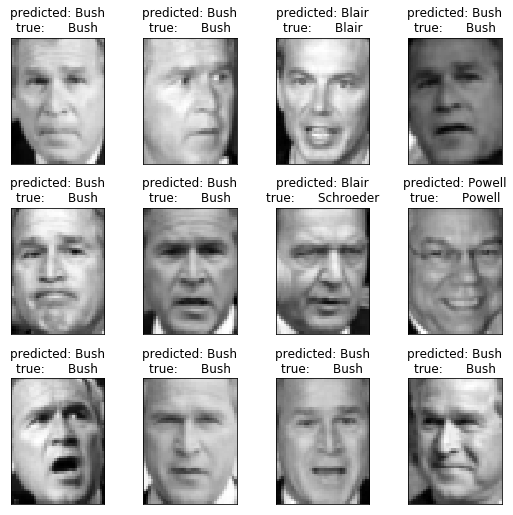

In [9]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())



# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return ('predicted: %s\ntrue:      %s' % (pred_name, true_name))

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

pl.show()

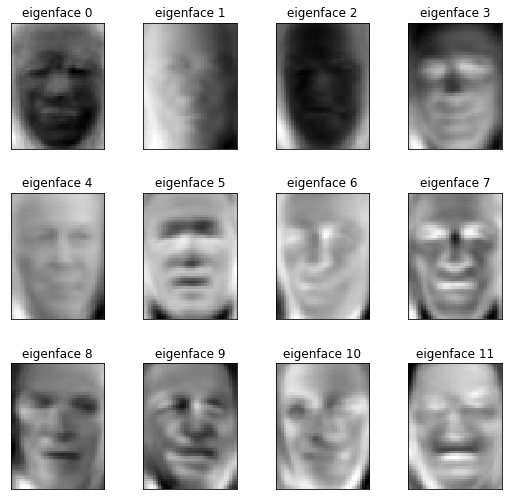

In [10]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()

## 练习：每个主成分的可释方差

我们提到 PCA 将对主成分排序，第一个主成分会显示最大方差的方向，第二个主成分具有第二大方差，等等。第一个主成分解释了多少方差？第二个呢？



## 练习：要使用多少个主成分？

现在你将实验不同数量的主成分。在多类别分类问题（例如此问题，要应用 2 个以上的标签）中，准确率指标没有二类别问题的准确率指标直观。相反，我们将使用一个热门指标，即 F1 分数。

我们将在关于评估指标的课程中深入了解 F1 分数，但是你自己将明白好的分类器的 F1 分数是高还是低。你将通过改变主成分的数量，观察 F1 分数会如何变化。

当你添加更多主成分（作为特征）来训练分类器时，你认为分类器的效果会更好还是更差？

## 练习：F1 分数与所使用的主成分数量

将 n_components 更改为以下值：[10、15、25、50、100、250]。对于每个主成分数量，注意 Ariel Sharon 的 F1 分数。（对于 10 个主成分，代码中的绘制函数将崩溃，但是你应该能够看到 F1 分数。）如果你看到更高的 F1 分数，是否意味着分类器的效果更好或更差？

## 练习：降维和过拟合
在使用很高数量的主成分时，是否看到任何过拟合现象？在这种情况下，PCA 降维是否能够改善效果？